# ROMY - Barometric Models

In [1]:
import os
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np

from src.baroseis import baroseis


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/home/andbro/anaconda3/envs/obs2/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/andbro/anaconda3/envs/obs2/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/traitlets/config/application.py", line 992, in la

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/home/andbro/anaconda3/envs/obs2/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/andbro/anaconda3/envs/obs2/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/traitlets/config/application.py", line 992, in la

AttributeError: _ARRAY_API not found

### Configurations

In [2]:
station = "ROMY" # "FUR" or "ROMY" or "DROMY"

# date = "20240312"
# date = "20240315"
# date = "20240321"
# date = "20240423"
date = "20240324"
# date = "20240829"

# Frequency range
fmin = 5e-4
fmax = 1e-2

save_figs = False

# select channel: A = tilt, J = rotation rate, H = acceleration
cha ="*A*"

# load config
config = baroseis.load_from_yaml(f"./config/config_FFBI_{station}_{date}_file.yaml")

path_to_figs = f"./figures/{date}/"

### Load Spatial Pressure Gradients

In [3]:
from functions.read_sds import read_sds

In [69]:
# gradient = obs.read(f"./data/pressure_gradient_{date}.mseed")
gradient = read_sds(f"./data/", "BW.PROMY.01.LDE", config['tbeg'], config['tend'])
gradient += read_sds(f"./data/", "BW.PROMY.01.LDN", config['tbeg'], config['tend'])


gradient = gradient.detrend("linear")
gradient = gradient.detrend("demean")
gradient = gradient.taper(0.05, "cosine")
gradient = gradient.filter("bandpass", freqmin=5e-4, freqmax=0.002, corners=4, zerophase=True)

gradient = gradient.trim(config['tbeg'], config['tend'])
gradient = gradient.detrend("demean")
gradient = gradient.taper(0.05, "cosine")
gradient

2 Trace(s) in Stream:
BW.PROMY.01.LDE | 2024-03-24T15:00:00.000000Z - 2024-03-24T17:00:00.000000Z | 1.0 Hz, 7201 samples
BW.PROMY.01.LDN | 2024-03-24T15:00:00.000000Z - 2024-03-24T17:00:00.000000Z | 1.0 Hz, 7201 samples

In [70]:
# Initialize baroseis object
bs = baroseis(conf=config)

# Load data specified in config
bs.load_data()

Creating new Hilbert transform data...
 -> No resampling required!

>Runtime: 0.0 minutes



In [71]:
bs.st

5 Trace(s) in Stream:
BW.FFBI..BDO   | 2024-03-24T14:00:00.005000Z - 2024-03-24T18:00:00.005000Z | 1.0 Hz, 14401 samples
BW.ROMY.40.BJE | 2024-03-24T13:59:59.997801Z - 2024-03-24T17:59:59.997801Z | 1.0 Hz, 14401 samples
BW.ROMY.40.BJN | 2024-03-24T13:59:59.989801Z - 2024-03-24T17:59:59.989801Z | 1.0 Hz, 14401 samples
BW.ROMY.40.BJZ | 2024-03-24T14:00:00.004199Z - 2024-03-24T18:00:00.004199Z | 1.0 Hz, 14401 samples
BW.FFBI..BDH   | 2024-03-24T14:00:00.005000Z - 2024-03-24T18:00:00.005000Z | 1.0 Hz, 14401 samples

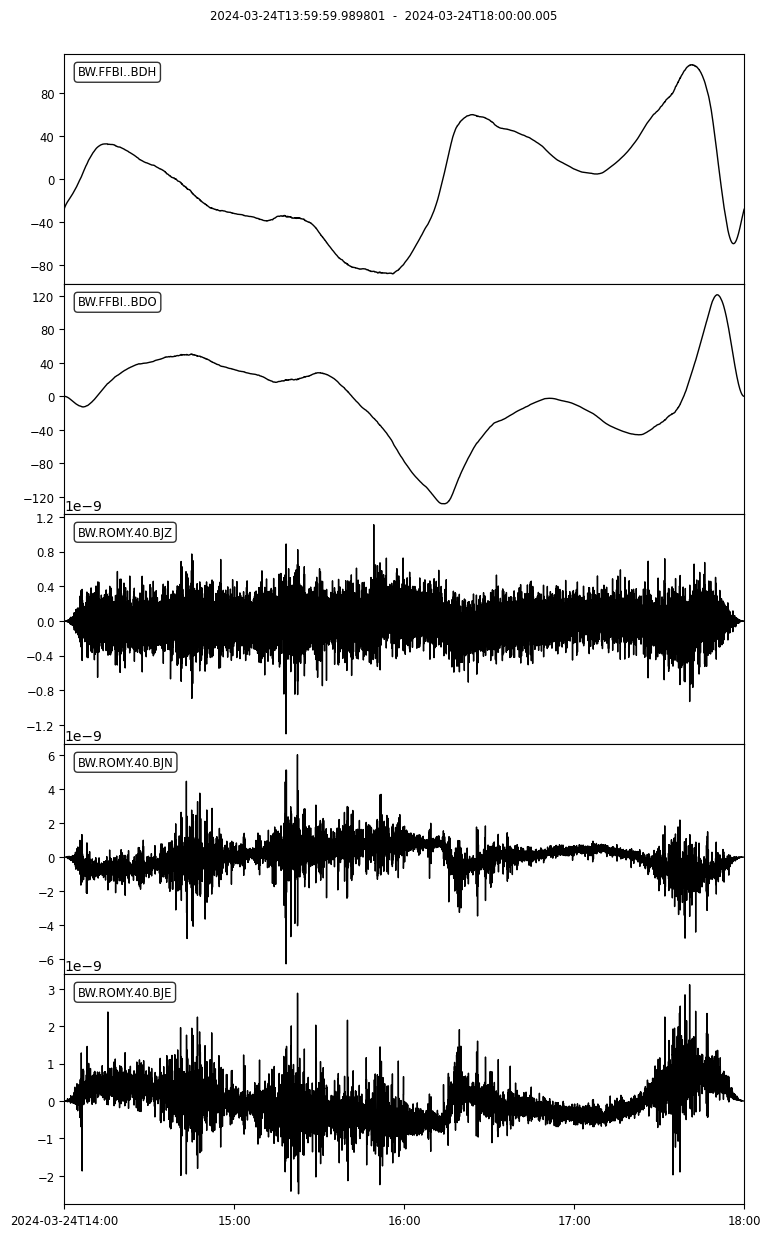

In [72]:
bs.st.plot(equal_scale=False);

Removing mean and trend...
Applying bandpass filter: 0.0005-0.01 Hz
 >Integrating ['JZ', 'JN', 'JE']


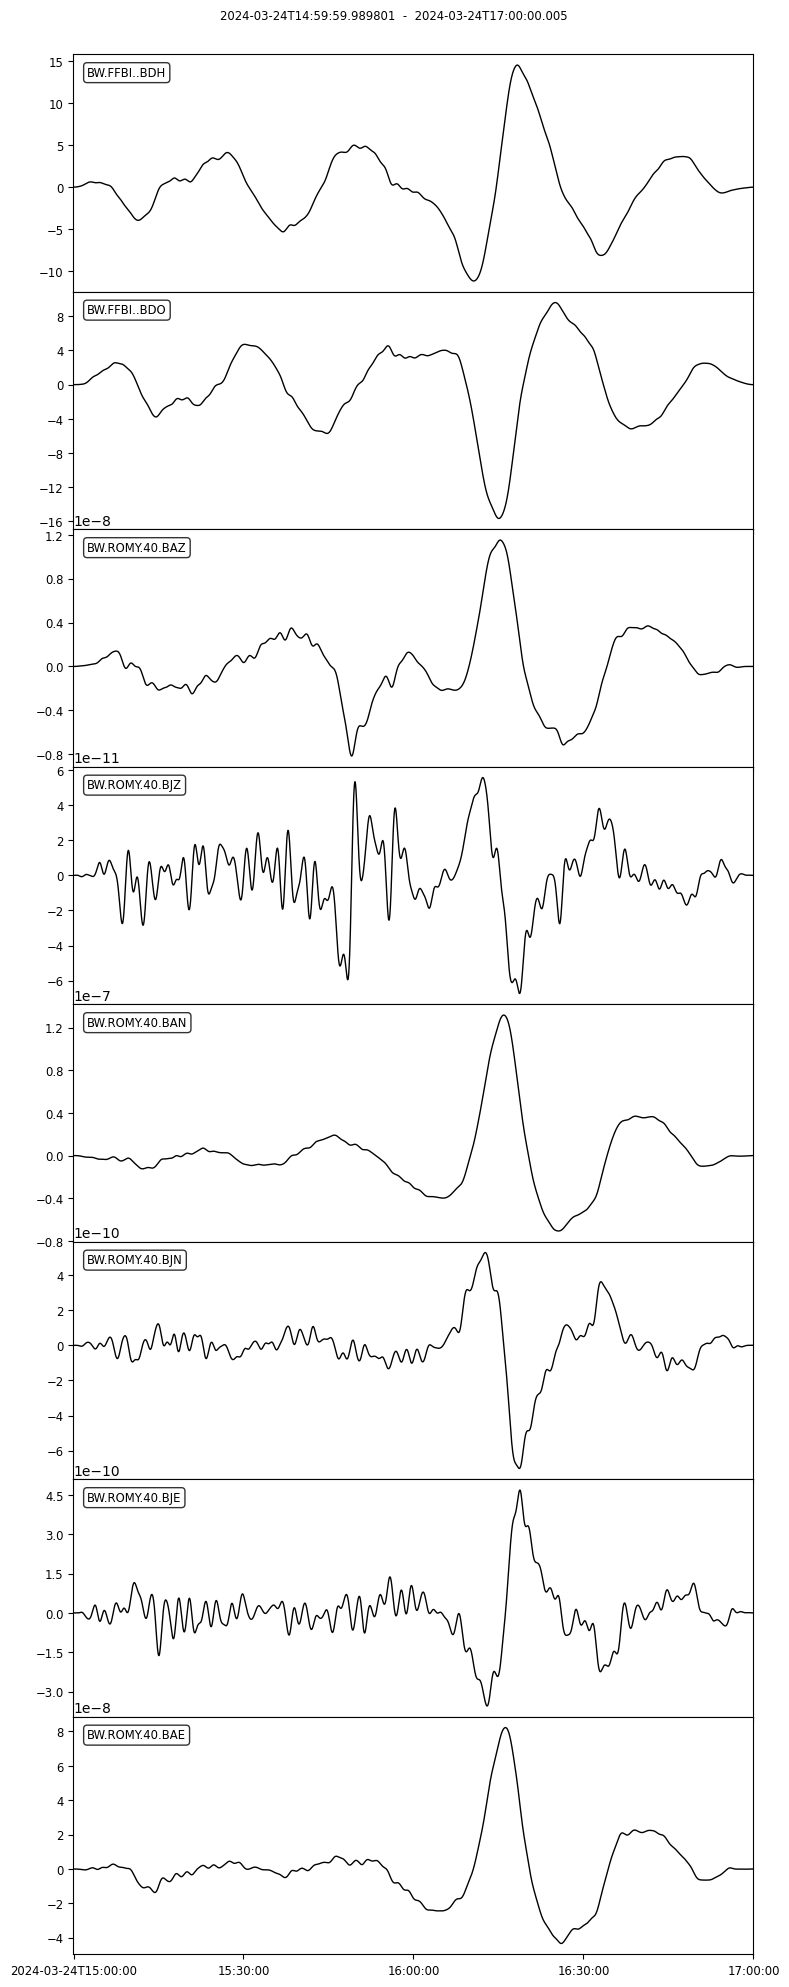

In [73]:
# band pass filer
bs.filter_data(fmin=fmin, fmax=fmax)

# detrend
bs.st.detrend("demean")

# taper edges
bs.st.taper(0.1, "cosine")

if station == "ROMY":
    # integrate rotation to tilt
    bs.integrate_data(method="cumtrapz") # method = "cumtrapz" or "spline"

elif station == "FUR" or station == "DROMY":
    # convert acceleration to tilt
    for tr in bs.st:
        if tr.stats.channel[1] == "H":
            tr.stats.channel = tr.stats.channel[0] + "A" + tr.stats.channel[-1]
            if tr.stats.channel[-1] in ["N", "E"]:
                tr.data = -tr.data/9.81
    
# trim waveforms
bs.st = bs.st.trim(bs.config['tbeg'], bs.config['tend'])

# detrend waveforms
bs.st.detrend("demean")

# taper edges
bs.st.taper(0.05, "cosine")

# show new waveforms
bs.st.plot(equal_scale=False);


In [74]:
st_plot = obs.Stream()

st_plot += bs.st.select(channel=f"*{cha}N").copy()[0]
st_plot += bs.st.select(channel=f"*{cha}E").copy()[0]
st_plot += bs.st.select(channel=f"*{cha}Z").copy()[0]

st_plot += bs.st.select(channel=f"*DO").copy()[0]
st_plot += bs.st.select(channel=f"*DH").copy()[0]

st_plot += gradient.select(channel=f"*DE").copy()[0]
st_plot += gradient.select(channel=f"*DN").copy()[0]




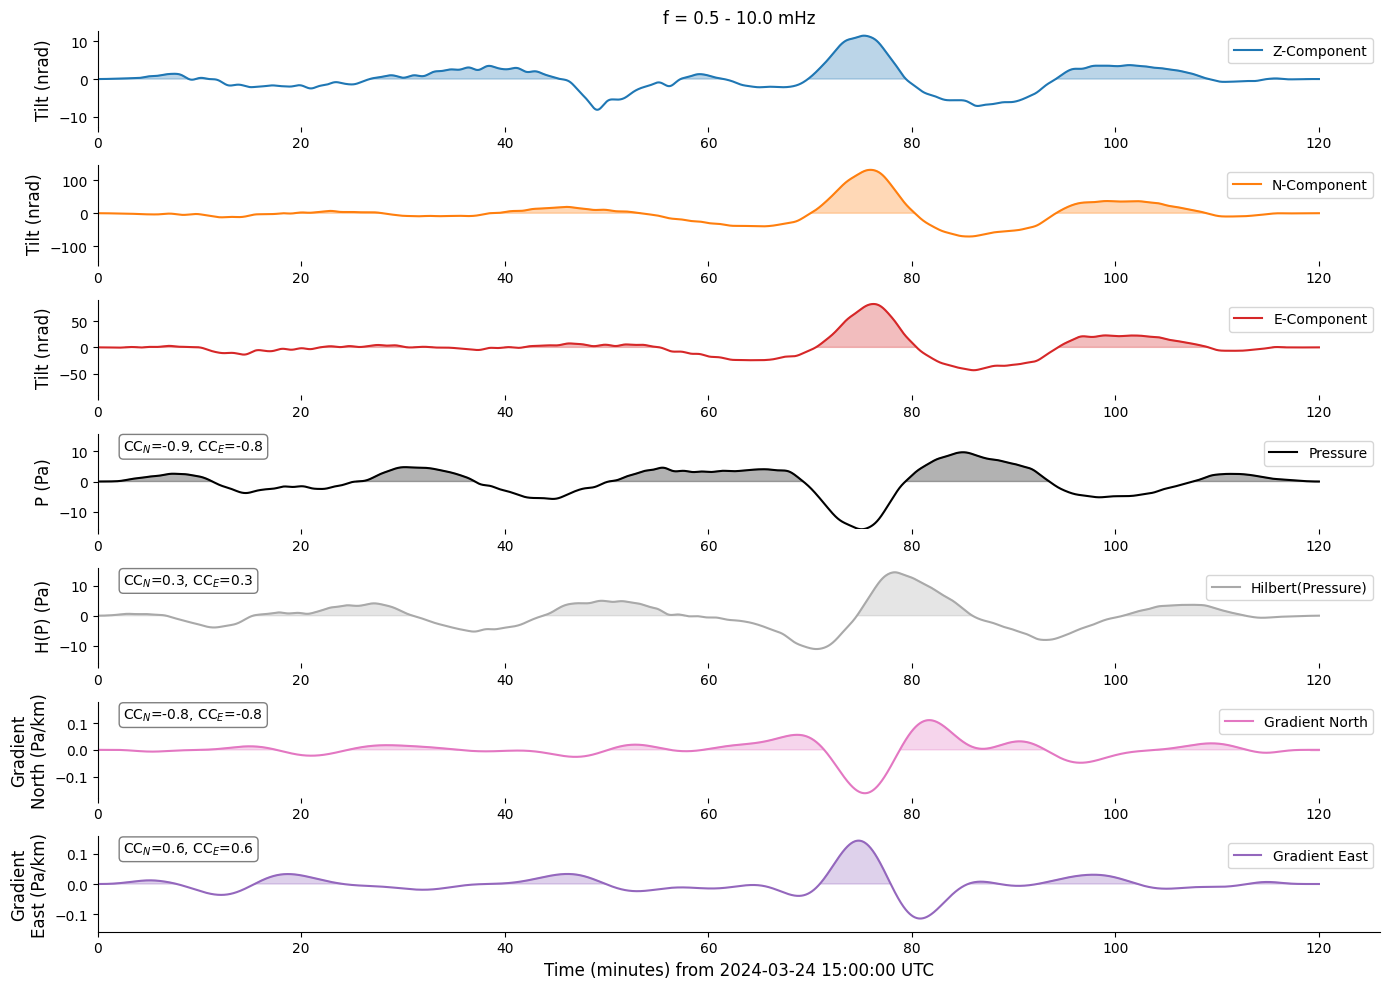

In [75]:
def plot_waveforms_with_gradient(st_plot, config, gradient_stream=None, fmin=None, fmax=None,
                                 time_unit="hours", channel_type="A", out=False):
    """
    Plot waveforms including tilt, pressure, hilbert, and gradient components.
    Shows cross-correlation values with tilt N and E components.
    
    Args:
        st_plot: Stream containing tilt (N, E, Z), pressure (DO), hilbert (DH), and optionally gradient (DE, DN)
        config: Configuration dictionary with tbeg, tend, fmin, fmax
        gradient_stream: Optional separate stream for gradient data (if not in st_plot)
        time_unit: Time unit for x-axis ('hours', 'days', 'minutes', 'seconds')
        channel_type: Channel type ('J' for rotation rate, 'A' for tilt, 'H' for acceleration)
        out: Return figure handle if True
        fmin: Minimum frequency for title
        fmax: Maximum frequency for title
    Returns:
        matplotlib.figure.Figure if out=True
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from obspy.signal.cross_correlation import correlate
    
    Nrow = 7  # Z, N, E tilt, Pressure, Hilbert, Gradient N, Gradient E
    yscale = 1e9
    font = 12
    
    # Set time scaling
    tscale_dict = {
        "hours": 1/3600,
        "days": 1/86400,
        "minutes": 1/60,
        "seconds": 1
    }
    tscale = tscale_dict.get(time_unit, 1/3600)
    
    fig, ax = plt.subplots(Nrow, 1, figsize=(14, 10))
    
    # Get tilt N and E data for cross-correlation
    try:
        tr_tilt_n = st_plot.select(channel=f"*{channel_type}N").copy()[0]
        tr_tilt_e = st_plot.select(channel=f"*{channel_type}E").copy()[0]
        tilt_n_data = tr_tilt_n.data
        tilt_e_data = tr_tilt_e.data
        sampling_rate = tr_tilt_n.stats.sampling_rate
    except:
        print("Warning: Could not find tilt N/E components for cross-correlation")
        tilt_n_data = None
        tilt_e_data = None
        sampling_rate = 1.0
    
    # Helper function to calculate zero-lag cross-correlation coefficient
    def calc_cc0(data1, data2):
        """Calculate zero-lag cross-correlation coefficient (normalized Pearson correlation)."""
        if data1 is None or data2 is None:
            return None
        min_len = min(len(data1), len(data2))
        if min_len == 0:
            return None
        d1 = data1[:min_len]
        d2 = data2[:min_len]
        
        # Use numpy corrcoef for normalized correlation coefficient
        corr_matrix = np.corrcoef(d1, d2)
        if np.isnan(corr_matrix[0, 1]):
            return 0.0
        return corr_matrix[0, 1]
    
    # Plot tilt components (Z, N, E)
    for comp, color, idx in zip(['Z', 'N', 'E'], ['tab:blue', 'tab:orange', 'tab:red'], range(3)):
        try:
            tr = st_plot.select(channel=f"*{channel_type}{comp}").copy()[0]
            times = tr.times(reftime=config['tbeg'])*tscale
            data = tr.data*yscale
            
            ax[idx].plot(times, data, label=f"{comp}-Component", color=color, linewidth=1.5)
            ax[idx].fill_between(times, 0, data,
                               where=data>0, interpolate=True,
                               color=color, alpha=0.3)
            ax[idx].set_ylim(-np.max(np.abs(data))*1.1, np.max(np.abs(data))*1.1)
        except Exception as e:
            print(f"Could not plot tilt component {comp}: {str(e)}")
    
    # Plot pressure
    try:
        tr_p = st_plot.select(channel="*DO").copy()[0]
        times = tr_p.times(reftime=config['tbeg'])*tscale
        data = tr_p.data
        
        # Calculate cross-correlations
        cc_n = calc_cc0(data, tilt_n_data)
        cc_e = calc_cc0(data, tilt_e_data)
        
        ax[3].plot(times, data, label="Pressure", color='k', linewidth=1.5)
        ax[3].fill_between(times, 0, data,
                          where=data>0, interpolate=True,
                          color='k', alpha=0.3)
        ax[3].set_ylim(-np.max(np.abs(data)), np.max(np.abs(data)))

        # Add cross-correlation text
        if cc_n is not None and cc_e is not None:
            text_str = f"CC$_N$={cc_n:.1f}, CC$_E$={cc_e:.1f}"
            ax[3].text(0.02, 0.95, text_str, transform=ax[3].transAxes,
                      fontsize=10, verticalalignment='top',
                      bbox=dict(boxstyle='round', facecolor='w', alpha=0.5))
    except Exception as e:
        print(f"Could not plot pressure data: {str(e)}")
    
    # Plot Hilbert transform
    try:
        tr_h = st_plot.select(channel="*DH").copy()[0]
        times = tr_h.times(reftime=config['tbeg'])*tscale
        data = tr_h.data
        
        # Calculate cross-correlations
        cc_n = calc_cc0(data, tilt_n_data)
        cc_e = calc_cc0(data, tilt_e_data)
        
        ax[4].plot(times, data, label="Hilbert(Pressure)", color='darkgrey', linewidth=1.5)
        ax[4].fill_between(times, 0, data,
                          where=data>0, interpolate=True,
                          color='darkgrey', alpha=0.3)
        ax[4].set_ylim(-np.max(np.abs(data))*1.1, np.max(np.abs(data))*1.1)

        # Add cross-correlation text
        if cc_n is not None and cc_e is not None:
            text_str = f"CC$_N$={cc_n:.1f}, CC$_E$={cc_e:.1f}"
            ax[4].text(0.02, 0.95, text_str, transform=ax[4].transAxes,
                      fontsize=10, verticalalignment='top',
                      bbox=dict(boxstyle='round', facecolor='w', alpha=0.5))
    except Exception as e:
        print(f"Could not plot Hilbert transform: {str(e)}")
    
    # Plot gradient components (N, E)
    gradient_st = gradient_stream if gradient_stream is not None else st_plot
    
    # Gradient North
    try:
        tr_gn = gradient_st.select(channel="*DN").copy()[0]
        times = tr_gn.times(reftime=config['tbeg'])*tscale
        data = tr_gn.data * 1e3  # Convert to Pa/km
        
        # Calculate cross-correlations
        cc_n = calc_cc0(data, tilt_n_data)
        cc_e = calc_cc0(data, tilt_e_data)
        
        ax[5].plot(times, data, label="Gradient North", color='tab:pink', linewidth=1.5)
        ax[5].fill_between(times, 0, data,
                          where=data>0, interpolate=True,
                          color='tab:pink', alpha=0.3)
        ax[5].set_ylim(-np.max(np.abs(data))*1.1, np.max(np.abs(data))*1.1)

        # Add cross-correlation text
        if cc_n is not None and cc_e is not None:
            text_str = f"CC$_N$={cc_n:.1f}, CC$_E$={cc_e:.1f}"
            ax[5].text(0.02, 0.95, text_str, transform=ax[5].transAxes,
                      fontsize=10, verticalalignment='top',
                      bbox=dict(boxstyle='round', facecolor='w', alpha=0.5))
    except Exception as e:
        print(f"Could not plot gradient North: {str(e)}")
    
    # Gradient East
    try:
        tr_ge = gradient_st.select(channel="*DE").copy()[0]
        times = tr_ge.times(reftime=config['tbeg'])*tscale
        data = tr_ge.data * 1e3  # Convert to Pa/km
        
        # Calculate cross-correlations
        cc_n = calc_cc0(data, tilt_n_data)
        cc_e = calc_cc0(data, tilt_e_data)
        
        ax[6].plot(times, data, label="Gradient East", color='tab:purple', linewidth=1.5)
        ax[6].fill_between(times, 0, data,
                          where=data>0, interpolate=True,
                          color='tab:purple', alpha=0.3)
        ax[6].set_ylim(-np.max(np.abs(data))*1.1, np.max(np.abs(data))*1.1)
        
        # Add cross-correlation text
        if cc_n is not None and cc_e is not None:
            text_str = f"CC$_N$={cc_n:.1f}, CC$_E$={cc_e:.1f}"
            ax[6].text(0.02, 0.95, text_str, transform=ax[6].transAxes,
                      fontsize=10, verticalalignment='top',
                      bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    except Exception as e:
        print(f"Could not plot gradient East: {str(e)}")
    
    # Format axes
    for _n in range(Nrow):
        ax[_n].legend(loc=1)
        ax[_n].spines[['right', 'top']].set_visible(False)
        if _n < Nrow-1:
            ax[_n].spines[['bottom']].set_visible(False)
    
    # Set labels
    for idx in range(3):
        if channel_type == "J":
            ax[idx].set_ylabel("Rotation Rate\n(nrad/s)", fontsize=font)
        elif channel_type == "A":
            ax[idx].set_ylabel("Tilt (nrad)", fontsize=font)
        elif channel_type == "H":
            ax[idx].set_ylabel("Acceleration (nm/s²)", fontsize=font)
    
    ax[3].set_ylabel("P (Pa)", fontsize=font)
    ax[4].set_ylabel("H(P) (Pa)", fontsize=font)
    ax[5].set_ylabel("Gradient\nNorth (Pa/km)", fontsize=font)
    ax[6].set_ylabel("Gradient\nEast (Pa/km)", fontsize=font)
    
    ax[Nrow-1].set_xlabel(f"Time ({time_unit}) from {config['tbeg'].strftime('%Y-%m-%d %H:%M:%S')} UTC", fontsize=font)
    
    for n in range(Nrow):
        ax[n].set_xlim(left=0)

    if fmin is not None and fmax is not None:
        ax[0].set_title(f"f = {fmin*1e3:.1f} - {fmax*1e3:.1f} mHz", fontsize=font)
    
    plt.tight_layout()
    
    if out:
        return fig
    else:
        plt.show()

# Usage example:
fig = plot_waveforms_with_gradient(
    st_plot,
    config,
    gradient_stream=gradient, 
    time_unit="minutes",
    channel_type="A",
    out=True,
    fmin=fmin,
    fmax=fmax
)

if save_figs:
    fig.savefig(f"{path_to_figs}{date}_{station}_{cha}_waveforms.png", dpi=150, bbox_inches="tight")

In [76]:
def model_tilt(seis_stream, pressure_data):
    """
    Simple model for predicting tilt/rotation from pressure data.
    
    Args:
        seis_stream: Stream with seismic data
        pressure_data: List of pressure arrays [P, H, DP, DH]
    
    Returns:
        Dictionary with predicted_data, coefficients, variance_reduction, residuals
    """
    
    # Get seismic data
    components = ['N', 'E', 'Z']
    seis_data = {}
    
    for comp in components:
        try:
            tr = seis_stream.select(component=comp).copy()[0]
            seis_data[comp] = tr.data
        except:
            continue
    
    if not seis_data:
        raise ValueError("No seismic data found")
    
    # Ensure all data has same length
    data_length = len(pressure_data[0])
    for comp in seis_data:
        if len(seis_data[comp]) != data_length:
            # Simple interpolation
            from scipy.interpolate import interp1d
            x_old = np.linspace(0, 1, len(seis_data[comp]))
            x_new = np.linspace(0, 1, data_length)
            f = interp1d(x_old, seis_data[comp], kind='linear', fill_value='extrapolate')
            seis_data[comp] = f(x_new)
    
    # Create design matrix
    A = np.column_stack(pressure_data)
    
    # Results
    results = {
        'predicted_data': {},
        'coefficients': {},
        'variance_reduction': {},
        'residuals': {}
    }
    
    # Process each component
    for comp, seis_comp_data in seis_data.items():
        # Least squares: A * x = b
        coefficients = np.linalg.lstsq(A, seis_comp_data, rcond=None)[0]
        predicted_data = A @ coefficients
        
        # Variance reduction
        original_var = np.var(seis_comp_data)
        residual_var = np.var(seis_comp_data - predicted_data)
        var_reduction = ((original_var - residual_var) / original_var) * 100
        
        # Store
        results['predicted_data'][comp] = predicted_data
        results['coefficients'][comp] = coefficients
        results['variance_reduction'][comp] = var_reduction
        results['residuals'][comp] = seis_comp_data - predicted_data
    
    return results

### Model 1

In [37]:
seis_stream = bs.st.select(channel=cha).copy()
model_data = [
    bs.st.select(channel="*DO").copy()[0].data,
    bs.st.select(channel="*DH").copy()[0].data,
]

# Run model
model1 = model_tilt(seis_stream, model_data)

# Access results
print("Variance reduction:")
for comp in model1['predicted_data']:
    print(f"{comp}: {model1['variance_reduction'][comp]:.1f}%")


Variance reduction:
N: 88.2%
E: 79.6%
Z: 55.7%


### Model 2

In [38]:
seis_stream = bs.st.select(channel=cha).copy()
pressure_data = [
    bs.st.select(channel="*DO").copy()[0].data,
    bs.st.select(channel="*DH").copy()[0].data,
    bs.st.select(channel="*DO").copy().differentiate()[0].data,
    bs.st.select(channel="*DH").copy().differentiate()[0].data
]

# Run model
model2 = model_tilt(seis_stream, pressure_data)

# Access results
print("Variance reduction:")
for comp in model2['predicted_data']:
    print(f"{comp}: {model2['variance_reduction'][comp]:.1f}%")


Variance reduction:
N: 88.4%
E: 80.3%
Z: 57.0%


### Model 3

In [39]:
seis_stream = bs.st.select(channel=cha).copy()
model_data = [
    bs.st.select(channel="*DO").copy()[0].data,
    bs.st.select(channel="*DH").copy()[0].data,
    gradient.select(channel="*DE")[0].data,
    gradient.select(channel="*DN")[0].data,
]

# Run model
model3 = model_tilt(seis_stream, model_data)

# Access results
print("Variance reduction:")
for comp in model3['predicted_data']:
    print(f"{comp}: {model3['variance_reduction'][comp]:.1f}%")

# Get predicted data
predicted_data = model3['predicted_data']
coefficients = model3['coefficients']
print(coefficients)

Variance reduction:
N: 92.1%
E: 86.7%
Z: 69.4%
{'N': array([-5.36379649e-09,  1.41854609e-09, -2.99896562e-04, -4.17849553e-04]), 'E': array([-2.66358396e-09,  1.02766510e-09, -2.62569875e-04, -3.51961002e-04]), 'Z': array([-2.95244716e-10, -1.25823626e-10, -5.09893527e-05, -7.63002124e-05])}


### Model 4

In [40]:
seis_stream = bs.st.select(channel=cha).copy()
model_data = [
    bs.st.select(channel="*DO").copy()[0].data,
    bs.st.select(channel="*DH").copy()[0].data,
    gradient.select(channel="*DE")[0].data,
    gradient.select(channel="*DN")[0].data,
    gradient.select(channel="*DE").copy().differentiate()[0].data,
    gradient.select(channel="*DN").copy().differentiate()[0].data,
]

# Run model
model4 = model_tilt(seis_stream, model_data)

# Access results
print("Variance reduction:")
for comp in model4['predicted_data']:
    print(f"{comp}: {model4['variance_reduction'][comp]:.1f}%")


Variance reduction:
N: 93.9%
E: 89.4%
Z: 70.7%


In [41]:
def plot_vr_comparison(model_list, figsize=(8, 5)):
    """
    Simple variance reduction comparison plot for a list of models.
    
    Args:
        model_list: List of dictionaries, each with 'name' and 'variance_reduction' keys
        figsize: Figure size tuple
    
    Example:
        models = [
            {'name': 'Basic', 'variance_reduction': {'N': 45, 'E': 38, 'Z': 52}},
            {'name': 'With Derivatives', 'variance_reduction': {'N': 67, 'E': 61, 'Z': 73}},
            {'name': 'Advanced', 'variance_reduction': {'N': 72, 'E': 69, 'Z': 79}}
        ]
        plot_vr_comparison(models)
    """
    import matplotlib.pyplot as plt
    import numpy as np

    # Colors for different models
    colors = ['tab:red', 'tab:green', 'tab:blue', 'tab:orange', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']
    
    components = ['N', 'E', 'Z']
    x = np.arange(len(components))
    width = 0.8 / len(model_list)
    
    fig, ax = plt.subplots(figsize=figsize)
    
    for i, model in enumerate(model_list):
        vr_values = [model['variance_reduction'].get(comp, 0) for comp in components]
        ax.bar(x + i * width, vr_values, width, 
               label=model['name'], color=colors[i % len(colors)], alpha=0.8)
        
    ax.set_ylabel('Variance Reduction (%)')
    ax.set_title('Variance Reduction Comparison')
    ax.set_xticks(x + width * (len(model_list) - 1) / 2)
    ax.set_xticklabels(f"{comp}-component" for comp in components)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 100)
    
    plt.tight_layout()
    return fig

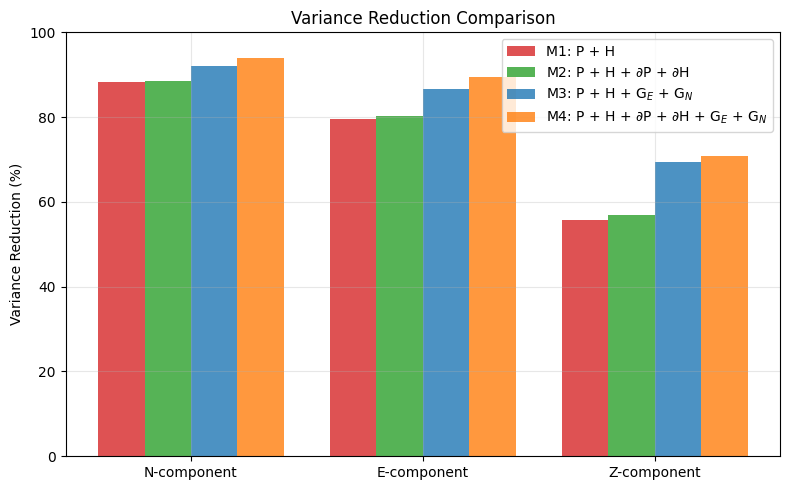

In [42]:
# Define your models
models = [
    {'name': r'M1: P + H', 'variance_reduction': model1['variance_reduction']},
    {'name': r'M2: P + H + $\partial$P + $\partial$H', 'variance_reduction': model2['variance_reduction']},
    {'name': r'M3: P + H + G$_E$ + G$_N$', 'variance_reduction':model3['variance_reduction']},
    {'name': r'M4: P + H + $\partial$P + $\partial$H + G$_E$ + G$_N$', 'variance_reduction':model4['variance_reduction']}
]

# Plot
fig = plot_vr_comparison(models)

if save_figs:
    fig.savefig(f"{path_to_figs}{date}_{station}_{cha}_model_vr_comparison.png", dpi=150, bbox_inches="tight")

In [43]:
def plot_waveform_comparison(seis_stream, model_results,
                           time_unit='minutes', residual=False, figsize=(15, 10)):
    """
    Simple plot with 3 vertical subplots (Z, N, E) showing waveforms for each model.
    
    Args:
        seis_stream: Original seismic stream
        model_results: Dictionary with model names as keys and results as values
        time_unit: Time unit for x-axis
        residual: Boolean to plot residuals
        figsize: Figure size
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Get time scaling
    tscale_dict = {"hours": 1/3600, "days": 1/86400, "minutes": 1/60, "seconds": 1}
    tscale = tscale_dict.get(time_unit, 1/60)
    
    # Set units and scaling
    channel_type = seis_stream[0].stats.channel[1]
    if channel_type == 'J':
        ylabel = "Rotation Rate\n(nrad/s)"
        yscale = 1e9
    elif channel_type == 'A':
        ylabel = "Tilt (nrad)"
        yscale = 1e9
    elif channel_type == 'H':
        ylabel = "Acceleration\n(nm/s²)"
        yscale = 1e9
    else:
        ylabel = "Amplitude"
        yscale = 1.0

    components = ['Z', 'N', 'E']
    
    font = 14

    # Create 3 vertical subplots
    fig, axes = plt.subplots(3, 1, figsize=figsize, sharex=True)
    
    # Colors for different models
    colors = ['tab:red', 'tab:green', 'tab:blue', 'tab:orange', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']
    
    # Plot each component
    for i, comp in enumerate(components):
        try:
            # Get original data
            orig_tr = seis_stream.select(channel=f"*{comp}").copy()[0]
            times = orig_tr.times() * tscale
            orig_data = orig_tr.data * yscale
            
            # Plot original data
            axes[i].plot(times, orig_data, 'k-', linewidth=2, 
                        label=f'{comp}-Component', alpha=1, zorder=1)
            max_orig = np.max(np.abs(orig_data))

            # Plot each model
            for j, (model_name, results) in enumerate(model_results.items()):
                if comp in results['predicted_data']:
                    pred_data = results['predicted_data'][comp] * yscale
                    var_reduction = results['variance_reduction'][comp]
                    
                    color = colors[j % len(colors)]
                    if residual:
                        res_data = orig_data - pred_data
                        axes[i].plot(times, res_data, color=color, linewidth=1.5, zorder=2,
                                label=f'M{j+1} (VR: {var_reduction:.1f}%)', alpha=0.9)
                        # find y absolute maximum for ylim
                        y_max = np.max([np.max(np.abs(res_data)), max_orig])*1.01
                        axes[i].set_ylim(-y_max, y_max)
                    else:
                        axes[i].plot(times, pred_data, color=color, linewidth=1.5, zorder=2,
                                label=f'M{j+1} (VR: {var_reduction:.1f}%)', alpha=0.9)
                        # find y absolute maximum for ylim
                        y_max = np.max([np.max(np.abs(pred_data)), max_orig])*1.01
                        axes[i].set_ylim(-y_max, y_max)
            # Format subplot
            axes[i].set_ylabel(f"{ylabel}", fontsize=font)
            axes[i].legend(fontsize=font-2, loc='lower left', ncol=5)
            axes[i].grid(True, alpha=0.3)
            axes[i].tick_params(labelsize=font-1)
    
        except Exception as e:
            print(f"Error plotting {comp}: {e}")
            axes[i].text(0.5, 0.5, f'Error loading {comp}', 
                        ha='center', va='center', transform=axes[i].transAxes)
            continue
    
    # Set x-axis label
    axes[-1].set_xlabel(f"Time ({time_unit})", fontsize=font)
    
    # Set overall title
    if residual:
        title = f"Residual Comparison"
    else:
        title = f"Model Comparison"
    fig.suptitle(title, fontsize=font+2, fontweight='bold')
    
    # Add model names as text outside the frame
    model_names = list(model_results.keys())
    model_text = "Models:  " + ",   ".join([f"{name}" for i, name in enumerate(model_names)])
    
    # Add text below the plot
    fig.text(0.5, 0.02, model_text, ha='center', va='bottom', fontsize=font-2, 
             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    # Adjust layout to make room for the model text
    plt.subplots_adjust(bottom=0.1)
    return fig

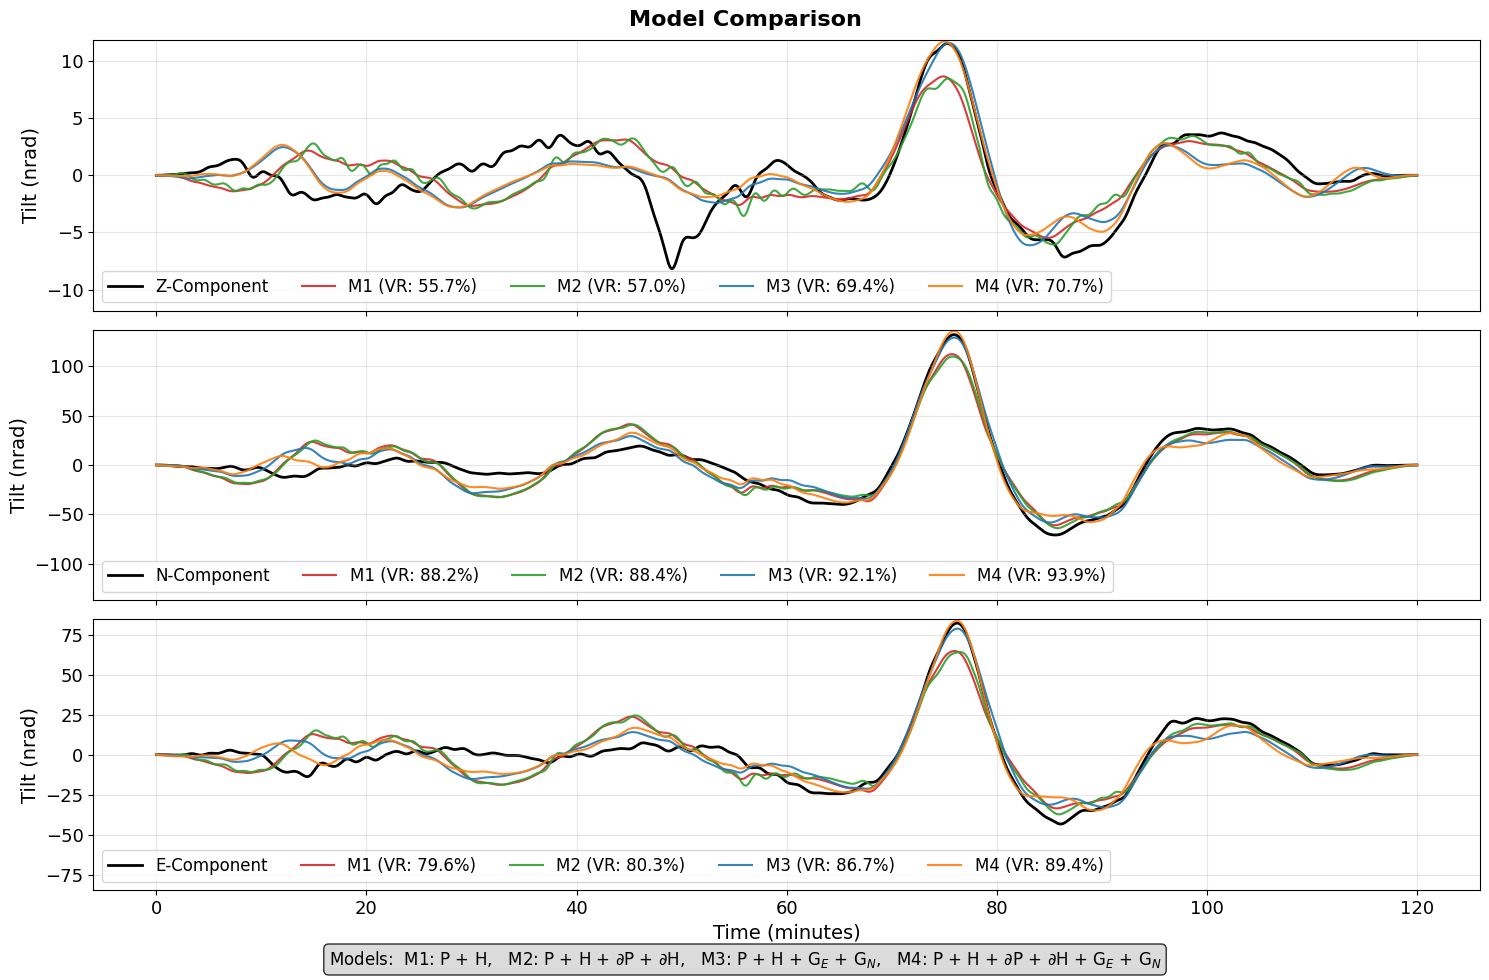

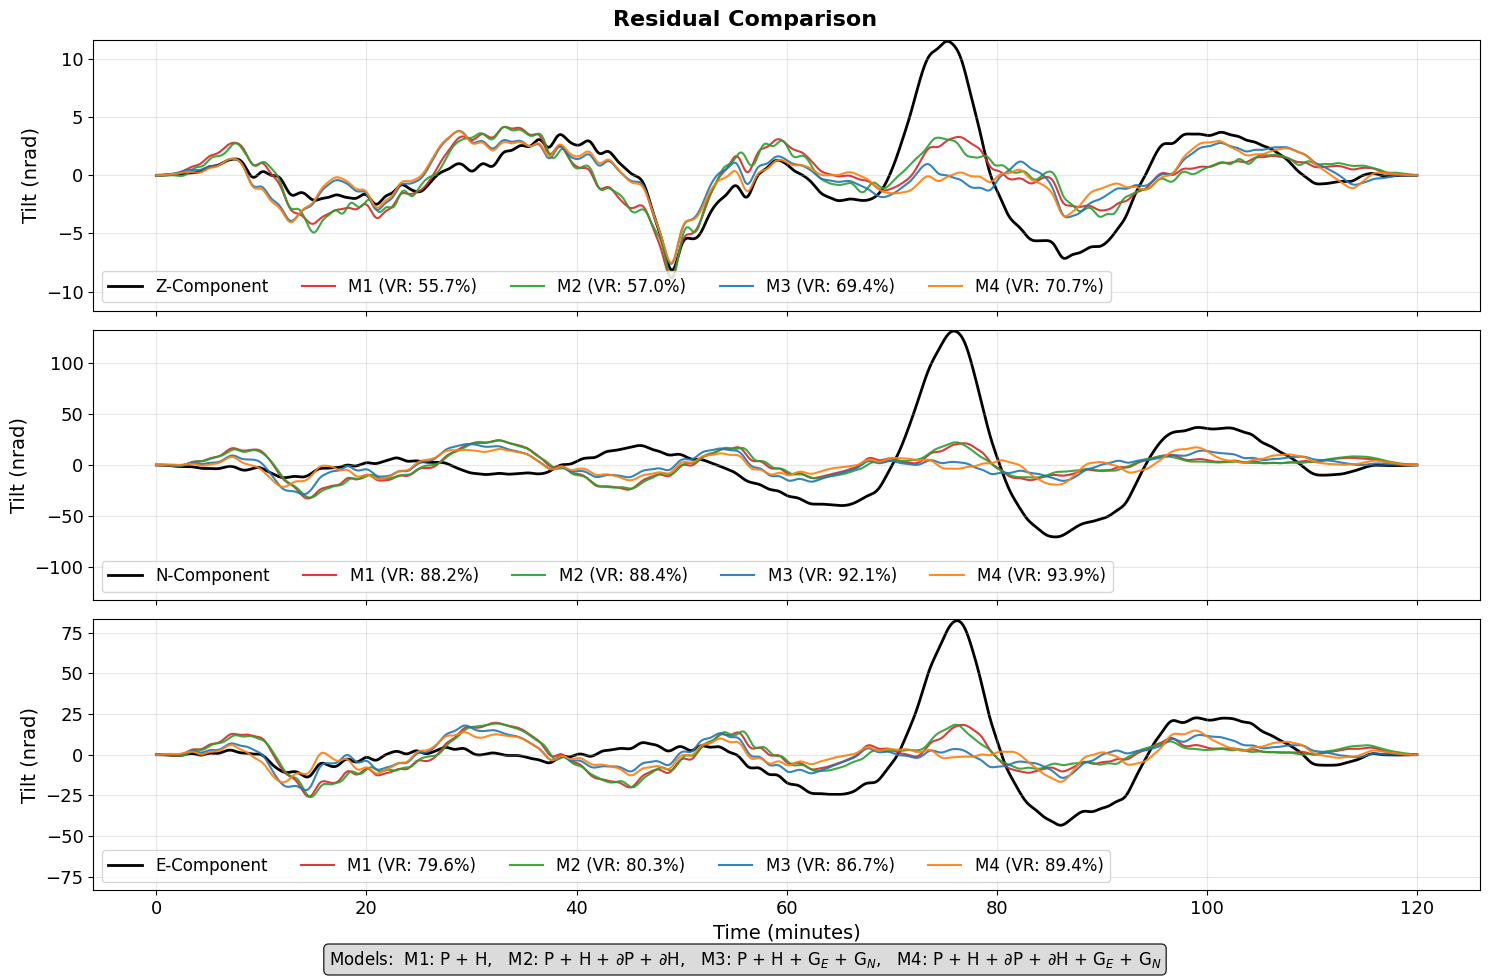

In [44]:
# Example usage:
model_results = {
    r'M1: P + H': model1,
    r'M2: P + H + $\partial$P + $\partial$H': model2,
    r'M3: P + H + G$_E$ + G$_N$': model3,
    r'M4: P + H + $\partial$P + $\partial$H + G$_E$ + G$_N$': model4
}

fig = plot_waveform_comparison(seis_stream, model_results)

if save_figs:
    fig.savefig(f"{path_to_figs}{date}_{station}_{cha}_model_waveform_comparison.png", dpi=150, bbox_inches="tight")


fig = plot_waveform_comparison(seis_stream, model_results, residual=True)

if save_figs:
    fig.savefig(f"{path_to_figs}{date}_{station}_{cha}_model_waveform_residual_comparison.png", dpi=150, bbox_inches="tight")


In [45]:
def plot_spectra_comparison(seis_stream, model_results,
                           method='welch', fmin=0.0005, fmax=0.03,
                           log_scale=True, db_scale=False, residual=False, 
                           smooth_octave=False, octave_fraction=1/3, 
                           smooth_method='median', figsize=(15, 10)):
    """
    Plot spectra comparison for 3 components (Z, N, E) showing spectra for each model.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy.signal import welch
    from scipy.fft import fft, fftfreq
    from scipy.signal import windows

    def smooth_octave_bands(freq, spectrum, octave_fraction=1/3, method='median'):
        """Smooth spectrum in fractional octave bands."""
        # Create octave band centers
        f_min = freq[freq > 0].min()
        f_max = freq.max()
        
        # Calculate number of octave bands
        n_octaves = int(np.log2(f_max / f_min) / octave_fraction) + 1
        
        # Create octave band centers
        f_centers = f_min * (2 ** (octave_fraction * np.arange(n_octaves)))
        
        # Calculate band edges
        f_lower = f_centers / (2 ** (octave_fraction / 2))
        f_upper = f_centers * (2 ** (octave_fraction / 2))
        
        # Initialize smoothed arrays
        freq_smooth = []
        spectrum_smooth = []
        
        for i in range(len(f_centers)):
            # Find frequencies within this octave band
            mask = (freq >= f_lower[i]) & (freq <= f_upper[i])
            
            if np.any(mask):
                if method == 'median':
                    smooth_val = np.median(spectrum[mask])
                else:  # mean
                    smooth_val = np.mean(spectrum[mask])
                
                freq_smooth.append(f_centers[i])
                spectrum_smooth.append(smooth_val)
        
        return np.array(freq_smooth), np.array(spectrum_smooth)

    # Set units and scaling
    channel_type = seis_stream[0].stats.channel[1]
    if channel_type == 'J':
        ylabel = "Rotation Rate\n(nrad/s)"
        yscale = 1e9
    elif channel_type == 'A':
        ylabel = "Tilt (nrad)"
        yscale = 1e9
    elif channel_type == 'H':
        ylabel = "Acceleration\n(nm/s²)"
        yscale = 1e9
    else:
        ylabel = "Amplitude"
        yscale = 1.0

    components = ['Z', 'N', 'E']
    font = 14

    # Create 3 vertical subplots
    fig, axes = plt.subplots(3, 1, figsize=figsize, sharex=True)
    
    # Colors for different models
    colors = ['tab:red', 'tab:green', 'tab:blue', 'tab:orange', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']
    
    # Plot each component
    for i, comp in enumerate(components):
        try:
            # Get original data
            orig_tr = seis_stream.select(channel=f"*{comp}").copy()[0]
            
            # Compute original spectrum
            if method.lower() == 'fft':
                n = len(orig_tr.data)
                win = windows.hann(n)
                spec_orig = fft(orig_tr.data * win)
                freq = fftfreq(n, d=orig_tr.stats.delta)
                pos_freq = freq[0:n//2]
                mag_orig = np.abs(spec_orig[0:n//2]) * 2.0/n * yscale
            else:  # welch
                nperseg = int(orig_tr.stats.sampling_rate * 3600)  # 1-hour segments
                noverlap = nperseg // 2
                freq, psd_orig = welch(orig_tr.data, fs=orig_tr.stats.sampling_rate,
                                     window='hann', nperseg=nperseg, noverlap=noverlap)
                mag_orig = np.sqrt(psd_orig) * yscale
                pos_freq = freq
            
            # Apply octave band smoothing if requested
            if smooth_octave:
                pos_freq, mag_orig = smooth_octave_bands(pos_freq, mag_orig, 
                                                        octave_fraction, smooth_method)
            
            # Convert to dB if requested
            if db_scale:
                mag_orig = 20 * np.log10(mag_orig)
                ylabel_comp = ylabel + " (dB)"
            else:
                ylabel_comp = ylabel
            
            # Apply frequency limits
            mask = (pos_freq >= fmin) & (pos_freq <= fmax)
            pos_freq_plot = pos_freq[mask]
            mag_orig_plot = mag_orig[mask]
            
            # Plot original spectrum
            axes[i].plot(pos_freq_plot, mag_orig_plot, 'k-', linewidth=2, 
                        label=f'{comp}-Component', alpha=1, zorder=1)

            # Plot each model
            for j, (model_name, results) in enumerate(model_results.items()):
                if comp in results['predicted_data']:
                    residual_tr = seis_stream.select(channel=f"*{comp}").copy()[0]
                    residual_tr.data = seis_stream.select(channel=f"*{comp}").copy()[0].data - results['predicted_data'][comp]
                    var_reduction = results['variance_reduction'][comp]
                    
                    # Compute predicted spectrum
                    if method.lower() == 'fft':
                        n = len(residual_tr.data)
                        win = windows.hann(n)
                        spec_pred = fft(residual_tr.data * win)
                        mag_pred = np.abs(spec_pred[0:n//2]) * 2.0/n * yscale
                        freq_pred = fftfreq(n, d=residual_tr.stats.delta)[0:n//2]
                    else:  # welch
                        nperseg = int(residual_tr.stats.sampling_rate * 3600)
                        noverlap = nperseg // 2
                        freq_pred, psd_pred = welch(residual_tr.data, fs=residual_tr.stats.sampling_rate,
                                                  window='hann', nperseg=nperseg, noverlap=noverlap)
                        mag_pred = np.sqrt(psd_pred) * yscale
                    
                    # Apply octave band smoothing if requested
                    if smooth_octave:
                        freq_pred, mag_pred = smooth_octave_bands(freq_pred, mag_pred, 
                                                                octave_fraction, smooth_method)
                    
                    # Convert to dB if requested
                    if db_scale:
                        mag_pred = 20 * np.log10(mag_pred)
                    
                    # Apply frequency limits
                    mask_pred = (freq_pred >= fmin) & (freq_pred <= fmax)
                    pos_freq_pred_plot = freq_pred[mask_pred]
                    mag_pred_plot = mag_pred[mask_pred]
                    
                    color = colors[j % len(colors)]
                    if residual:
                        # For residuals, we need to interpolate to match frequencies
                        from scipy.interpolate import interp1d
                        f_interp = interp1d(pos_freq_plot, mag_orig_plot, kind='linear', 
                                          bounds_error=False, fill_value=0)
                        mag_orig_interp = f_interp(pos_freq_pred_plot)
                        res_spectrum = mag_orig_interp - mag_pred_plot
                        axes[i].plot(pos_freq_pred_plot, res_spectrum, color=color, linewidth=1.5, zorder=2,
                                label=f'M{j+1} (VR: {var_reduction:.1f}%)', alpha=0.9)
                    else:
                        axes[i].plot(pos_freq_pred_plot, mag_pred_plot, color=color, linewidth=1.5, zorder=2,
                                label=f'M{j+1} (VR: {var_reduction:.1f}%)', alpha=0.9)
            
            # Format subplot
            if db_scale:
                axes[i].set_ylabel(r"ASD (dB wrt. nrad/$\sqrt{Hz}$)", fontsize=font)
            else:
                axes[i].set_ylabel(r"ASD nrad/$\sqrt{Hz}$", fontsize=font)
            axes[i].legend(loc='lower left', fontsize=font-2, ncol=5)
            axes[i].grid(True, alpha=0.3)
            axes[i].tick_params(labelsize=font-1)
            axes[i].set_xlim(fmin, fmax)
            
            # Set scales
            if log_scale:
                axes[i].set_xscale('log')
                if not db_scale:  # Only use log scale for y-axis if not in dB
                    axes[i].set_yscale('log')
    
        except Exception as e:
            print(f"Error plotting {comp}: {e}")
            axes[i].text(0.5, 0.5, f'Error loading {comp}', 
                        ha='center', va='center', transform=axes[i].transAxes)
            continue
    
    # Set x-axis label
    axes[-1].set_xlabel("Frequency (Hz)", fontsize=font)
    
    # Set overall title
    if residual:
        title = f"Spectra Residual Comparison"
    else:
        title = f"Spectra Model Comparison"
    
    fig.suptitle(title, fontsize=font+2, fontweight='bold')
    
    # Add model names as text outside the frame
    model_names = list(model_results.keys())
    model_text = "Models:  " + ",   ".join([f"{name}" for i, name in enumerate(model_names)])
    
    # Add text below the plot
    fig.text(0.5, 0.02, model_text, ha='center', va='bottom', fontsize=font-2, 
             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    # Adjust layout to make room for the model text
    plt.subplots_adjust(bottom=0.1)

    return fig

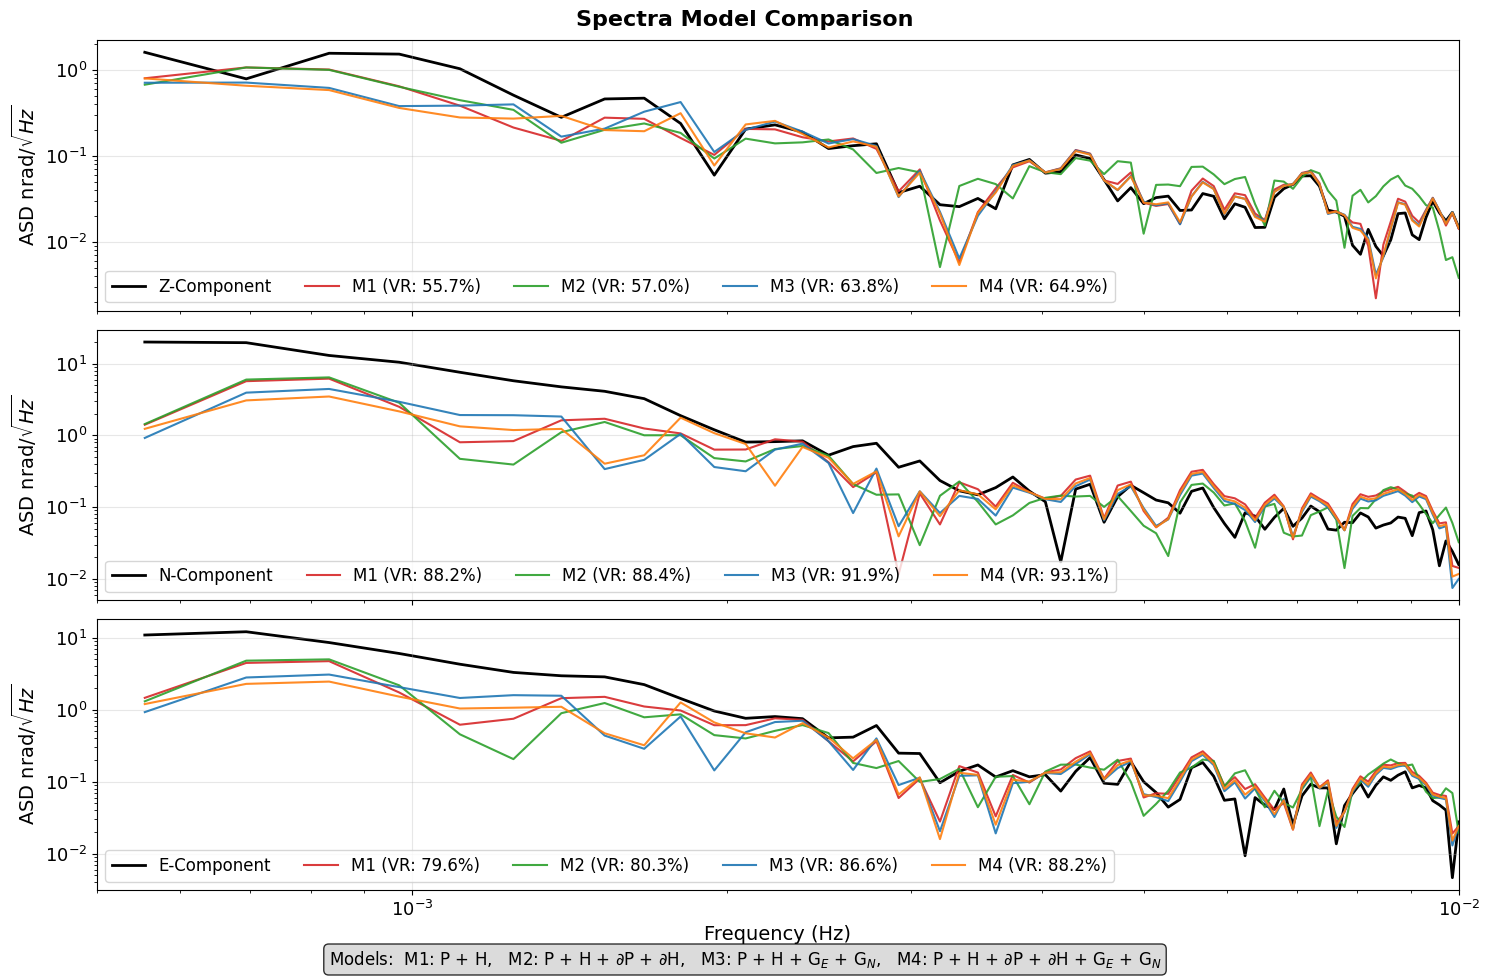

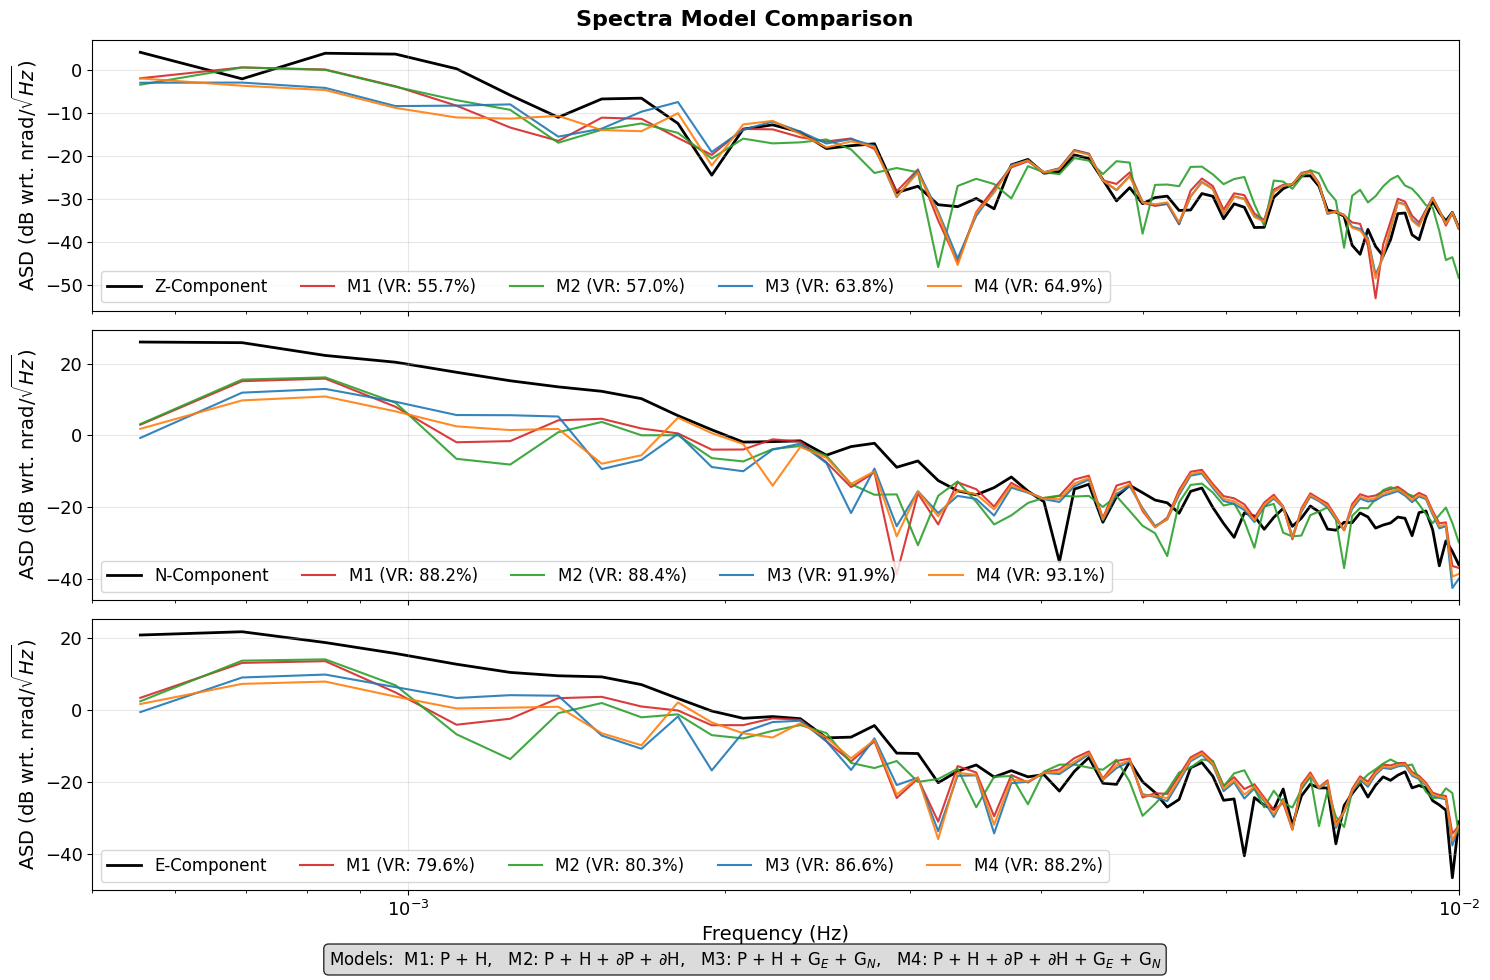

In [21]:
# ASD scale
fig = plot_spectra_comparison(seis_stream, model_results, method='fft', db_scale=False, fmin=fmin, fmax=fmax)

if save_figs:
    fig.savefig(f"{path_to_figs}{date}_{station}_{cha}_model_spectra_comparison.png", dpi=150, bbox_inches="tight")

# dB scale
fig = plot_spectra_comparison(seis_stream, model_results, method='fft', db_scale=True, fmin=fmin, fmax=fmax)

if save_figs:
    fig.savefig(f"{path_to_figs}{date}_{station}_{cha}_model_spectra_comparison_db.png", dpi=150, bbox_inches="tight")


# fig = plot_spectra_comparison(seis_stream, model_results, method='fft',
#                              smooth_octave=True, octave_fraction=1/6, smooth_method='median')

In [22]:
def plot_spectra_comparison(seis_stream, model_results, fmin=0.0005, fmax=0.03, 
                           smooth_octave=False, octave_fraction=1/3, smooth_method='median', 
                           figsize=(15, 10)):
    """
    Plot spectral difference comparison for 3 components (Z, N, E) showing difference of spectra in dB.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy.fft import fft, fftfreq
    from scipy.signal import windows

    def smooth_octave_bands(freq, spectrum, octave_fraction=1/3, method='median'):
        """Smooth spectrum in fractional octave bands."""
        # Create octave band centers
        f_min = freq[freq > 0].min()
        f_max = freq.max()
        
        # Calculate number of octave bands
        n_octaves = int(np.log2(f_max / f_min) / octave_fraction) + 1
        
        # Create octave band centers
        f_centers = f_min * (2 ** (octave_fraction * np.arange(n_octaves)))
        
        # Calculate band edges
        f_lower = f_centers / (2 ** (octave_fraction / 2))
        f_upper = f_centers * (2 ** (octave_fraction / 2))
        
        # Initialize smoothed arrays
        freq_smooth = []
        spectrum_smooth = []
        
        for i in range(len(f_centers)):
            # Find frequencies within this octave band
            mask = (freq >= f_lower[i]) & (freq <= f_upper[i])
            
            if np.any(mask):
                if method == 'median':
                    smooth_val = np.median(spectrum[mask])
                else:  # mean
                    smooth_val = np.mean(spectrum[mask])
                
                freq_smooth.append(f_centers[i])
                spectrum_smooth.append(smooth_val)
        
        return np.array(freq_smooth), np.array(spectrum_smooth)

    # Set units and scaling
    channel_type = seis_stream[0].stats.channel[1]
    if channel_type == 'J':
        ylabel = "Rotation Rate\n(nrad/s)"
        yscale = 1e9
    elif channel_type == 'A':
        ylabel = "Tilt (nrad)"
        yscale = 1e9
    elif channel_type == 'H':
        ylabel = "Acceleration\n(nm/s²)"
        yscale = 1e9
    else:
        ylabel = "Amplitude"
        yscale = 1.0

    components = ['Z', 'N', 'E']
    font = 14

    # Create 3 vertical subplots
    fig, axes = plt.subplots(3, 1, figsize=figsize, sharex=True)
    
    # Colors for different models
    colors = ['tab:red', 'tab:green', 'tab:blue', 'tab:orange', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']
    
    # Plot each component
    for i, comp in enumerate(components):
        try:
            # Get original data
            orig_tr = seis_stream.select(channel=f"*{comp}").copy()[0]
            
            # Compute original spectrum
            n = len(orig_tr.data)
            win = windows.hann(n)
            spec_orig = fft(orig_tr.data * win)
            freq = fftfreq(n, d=orig_tr.stats.delta)
            pos_freq = freq[0:n//2]
            mag_orig = np.abs(spec_orig[0:n//2]) * 2.0/n * yscale
            
            # Apply octave band smoothing to original spectrum if requested
            if smooth_octave:
                pos_freq, mag_orig = smooth_octave_bands(pos_freq, mag_orig, 
                                                        octave_fraction, smooth_method)
            
            # Plot each model spectral difference
            for j, (model_name, results) in enumerate(model_results.items()):
                if comp in results['predicted_data']:
                    residual_tr = seis_stream.select(channel=f"*{comp}").copy()[0]
                    residual_tr.data = orig_tr.data - results['predicted_data'][comp]
                    var_reduction = results['variance_reduction'][comp]
                    
                    # Compute residual spectrum
                    spec_residual = fft(residual_tr.data * win)
                    mag_residual = np.abs(spec_residual[0:n//2]) * 2.0/n * yscale
                    freq_residual = freq[0:n//2]  # Use original frequency array
                    
                    # Apply octave band smoothing to residual spectrum if requested
                    if smooth_octave:
                        freq_residual, mag_residual = smooth_octave_bands(freq_residual, mag_residual, 
                                                                        octave_fraction, smooth_method)
                    
                    # For interpolation when smoothing is used
                    if smooth_octave:
                        from scipy.interpolate import interp1d
                        # Interpolate residual spectrum to match original frequency grid
                        f_interp = interp1d(freq_residual, mag_residual, kind='linear', 
                                          bounds_error=False, fill_value=0)
                        mag_residual_interp = f_interp(pos_freq)
                        
                        # Compute spectral difference using interpolated residual
                        mag_diff_db = 20 * np.log10(mag_residual_interp / mag_orig)
                        
                        # Apply frequency limits
                        mask = (pos_freq >= fmin) & (pos_freq <= fmax)
                        pos_freq_plot = pos_freq[mask]
                        mag_diff_plot = mag_diff_db[mask]
                    else:
                        # No smoothing - use original arrays
                        mag_diff_db = 20 * np.log10(mag_residual / mag_orig)
                        
                        # Apply frequency limits
                        mask = (pos_freq >= fmin) & (pos_freq <= fmax)
                        pos_freq_plot = pos_freq[mask]
                        mag_diff_plot = mag_diff_db[mask]
                    
                    color = colors[j % len(colors)]
                    axes[i].plot(pos_freq_plot, mag_diff_plot, color=color, linewidth=1.5, zorder=2,
                                label=f'M{j+1} Spectral Diff (VR: {var_reduction:.1f}%)', alpha=0.9)
            
            # Format subplot
            axes[i].set_ylabel(f"Spectral Difference\n(dB w.r.t. nrad/" + r"$\sqrt{Hz}$" + ")", fontsize=font)
            axes[i].legend(loc='lower left', fontsize=font-2, ncol=2)
            axes[i].grid(True, alpha=0.3)
            axes[i].tick_params(labelsize=font-1)
            
            # Set scales
            axes[i].set_xscale('log')
    
        except Exception as e:
            print(f"Error plotting {comp}: {e}")
            axes[i].text(0.5, 0.5, f'Error loading {comp}', 
                        ha='center', va='center', transform=axes[i].transAxes)
            continue
    
    # Set x-axis label
    axes[-1].set_xlabel("Frequency (Hz)", fontsize=font)
    
    # Set overall title
    title = "Spectral Difference Comparison (Original - Predicted) in dB"
    if smooth_octave:
        title += f" - Smoothed ({octave_fraction:.1f} octave, {smooth_method})"
    fig.suptitle(title, fontsize=font+2, fontweight='bold')
    
    # Add model names as text outside the frame
    model_names = list(model_results.keys())
    model_text = "Models:  " + ",   ".join([f"{name}" for i, name in enumerate(model_names)])
    
    # Add text below the plot
    fig.text(0.5, 0.02, model_text, ha='center', va='bottom', fontsize=font-2, 
             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    # Adjust layout to make room for the model text
    plt.subplots_adjust(bottom=0.1)
    return fig

In [23]:
# fig = plot_spectra_comparison(seis_stream, model_results, 
#                              smooth_octave=True, octave_fraction=1/2, smooth_method='median')


In [24]:
def plot_three_scatter(bs0, gradient0, figsize=(15, 5)):
    """
    Plot three scatter plots side by side, color-coded by elapsed time.
    
    Args:
        bs: baroseis object with st attribute
        gradient: ObsPy Stream with gradient data
        figsize: Figure size tuple
    """
    import matplotlib.pyplot as plt
    import numpy as np
    

    _st = bs.st.copy()
    _gradient = gradient0.copy()

    # Get data
    do_data = _st.select(channel="*DO").copy()[0].data
    dh_data = _st.select(channel="*DH").copy()[0].data
    ae_data = _st.select(channel="*AE").copy()[0].data
    an_data = _st.select(channel="*AN").copy()[0].data
    de_data = _gradient.select(channel="*DE").copy()[0].data
    dn_data = _gradient.select(channel="*DN").copy()[0].data
    
    # Get elapsed time for color coding
    times = bs.st.select(channel="*DO").copy()[0].times() / 3600  # Convert to hours
    
    # Create figure with three subplots
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # Plot 1: DO vs DH
    scatter1 = axes[1].scatter(do_data, dh_data, c=times, cmap='viridis', 
                              alpha=0.6, s=10, edgecolors='none')
    axes[1].set_xlabel('Pressure (Pa)', fontsize=12)
    axes[1].set_ylabel('Hilbert(Pressure) (Pa)', fontsize=12)
    axes[1].set_title('Air Pressure', fontsize=12)
    axes[1].grid(True, alpha=0.3)
    
    # Plot 2: AE vs AN
    scatter2 = axes[0].scatter(ae_data*1e9, an_data*1e9, c=times, cmap='viridis', 
                              alpha=0.6, s=10, edgecolors='none')
    axes[0].set_xlabel('Tilt East (nrad)', fontsize=12)
    axes[0].set_ylabel('Tilt North (nrad)', fontsize=12)
    axes[0].set_title('Ground Tilt', fontsize=12)
    axes[0].grid(True, alpha=0.3)
    
    # Plot 3: DE vs DN
    scatter3 = axes[2].scatter(de_data*1e3, dn_data*1e3, c=times, cmap='viridis', 
                              alpha=0.6, s=10, edgecolors='none')
    axes[2].set_xlabel('Pressure Gradient East (Pa/km)', fontsize=12)
    axes[2].set_ylabel('Pressure Gradient North (Pa/km)', fontsize=12)
    axes[2].set_title('Spatial Pressure Gradient', fontsize=12)
    axes[2].grid(True, alpha=0.3)
    
    # Add colorbar outside the last subplot
    plt.tight_layout()
    cax = plt.axes([1.02, 0.12, 0.02, 0.8])
    cbar = plt.colorbar(scatter1, cax=cax, orientation='vertical')
    cbar.set_label('Time (hours)', fontsize=12)
    
    return fig


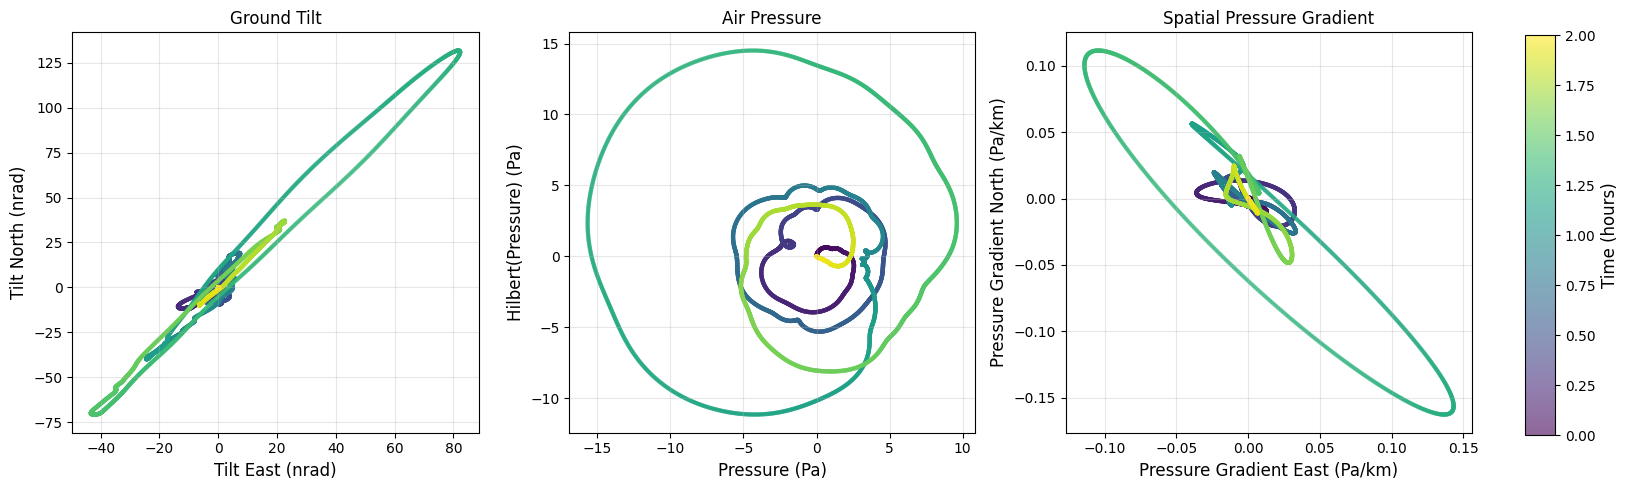

In [25]:
# Create the plot
fig = plot_three_scatter(bs, gradient)

In [26]:
def max_cross_correlation(data1, data2, max_lag_samples=None, sampling_rate=1.0):
    """
    Calculate maximum cross-correlation value between two data arrays with optional maximum time lag.
    
    Args:
        data1: First data array
        data2: Second data array
        max_lag_samples: Maximum lag in samples (if None, uses full length)
        sampling_rate: Sampling rate in Hz (for lag time calculation)
    
    Returns:
        dict with keys:
            - 'max_correlation': Maximum correlation value
            - 'lag_samples': Lag in samples at maximum correlation
            - 'lag_time': Lag in seconds at maximum correlation
    """
    from obspy.signal.cross_correlation import correlate
    import numpy as np
    
    # Determine maximum lag
    if max_lag_samples is None:
        max_lag_samples = min(len(data1), len(data2)) - 1
    
    # Ensure arrays are same length
    min_len = min(len(data1), len(data2))
    data1 = data1[:min_len]
    data2 = data2[:min_len]
    
    # Calculate cross-correlation
    correlation = correlate(data1, data2, shift=max_lag_samples)
    cc0 = correlate(data1, data2, shift=0)[0]
    print(cc0)
    # Find maximum correlation
    max_idx = np.argmax(np.abs(correlation))
    max_correlation = correlation[max_idx]
    
    # Calculate lag (shift from center)
    lag_samples = max_idx - max_lag_samples
    
    # Convert to time
    lag_time = lag_samples / sampling_rate
    
    print(f"CC0: {cc0:.2f} |  CCmax: {max_correlation:.2f} at lag {lag_time:.2f} seconds")

    return {
        'max_correlation': float(max_correlation),
        'lag_samples': int(lag_samples),
        'lag_time': float(lag_time)
    }

In [27]:
sps = 1
max_lag = 300/sps

result_N = max_cross_correlation(
    bs.st.select(channel="*AN").copy()[0].data,
    gradient.select(channel="*DN").copy()[0].data,
    max_lag_samples=int(max_lag),
    sampling_rate=int(sps)
)

result_E = max_cross_correlation(
    bs.st.select(channel="*AE").copy()[0].data,
    gradient.select(channel="*DE").copy()[0].data,
    max_lag_samples=int(max_lag),
    sampling_rate=int(sps)
)


-0.7924646597670809
CC0: -0.79 |  CCmax: -0.82 at lag 44.00 seconds
0.5589925104667303
CC0: 0.56 |  CCmax: 0.74 at lag 116.00 seconds


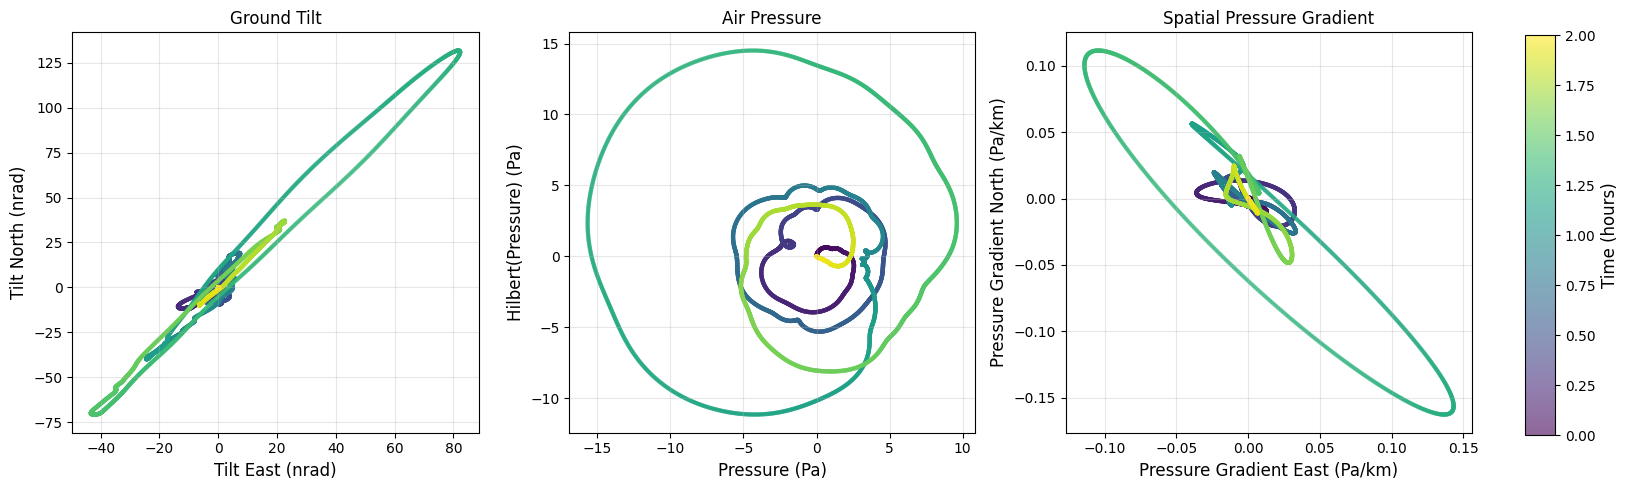

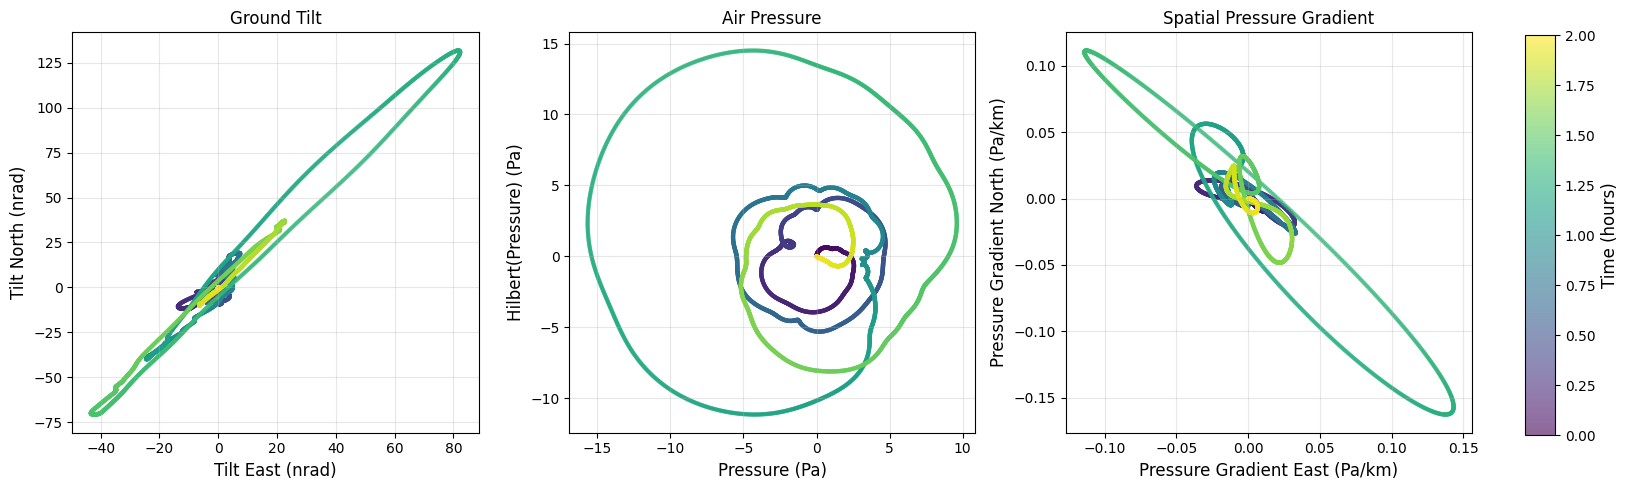

In [28]:
gradient_shifted = gradient.copy()
for tr in gradient_shifted:
    if 'DN' in tr.stats.channel:
        tr.data = np.roll(tr.data, result_N['lag_samples'])
    elif 'DE' in tr.stats.channel:
        tr.data = np.roll(tr.data, result_E['lag_samples'])

fig = plot_three_scatter(bs, gradient)
fig = plot_three_scatter(bs, gradient_shifted)